# Functional Connectivity Matrix (FCM)

In order to make functional connectivity matrices, the resting fMRI data needs to be preprocessed. These are important steps according to [FunConPy](https://github.com/vascosa/FunConPy): 

1. Slice time correction;
2. Motion correction;
3. Skull-stripping;
4. Normalization/registration to MNI template;
5. Regress out CSF and WM signal;
6. Detrending;
7. Bandpass filtering;
8. Smoothing;
9. Parcellation and time-series creation.

Also see [Varoquaux and Craddock, 2013](https://www.sciencedirect.com/science/article/pii/S1053811913003340). 

In the provided IMAGEN files, steps 1–4 and 6 are already performed, as can be seen in the [IMAGEN documentation](https://github.com/imagen2/imagen_processing/tree/master/rsfMRI_preprocessing).

In this notebook, I will load the preprocessed images and perform 
- step 5 by adding the CSF and WM signals as confounds (explained below); 
- step 7 by entering the default values 0.08 and 0.01 as lowpass and highpass respectively; 
- step 9 with the AAL atlas.

Most of these preprocessing steps are performed with `nilearn`.

In [1]:
import pandas as pd
import numpy as np
import glob
from os.path import join
from joblib import Parallel, delayed

import nibabel as nib 
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker
from nilearn.datasets import fetch_atlas_aal, fetch_atlas_harvard_oxford, fetch_icbm152_2009
from nilearn.connectome import ConnectivityMeasure

DATA_DIR = "/ritter/share/data/IMAGEN"

/home/evert/miniconda3/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


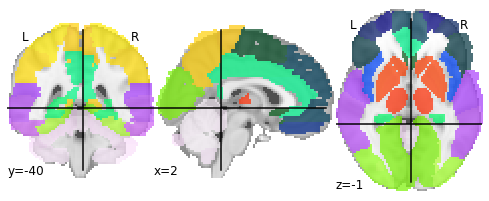

In [2]:
# Load the AAL atlas

dataset = fetch_atlas_aal()
atlas_filename = dataset.maps
labels = dataset.labels
plotting.plot_roi(atlas_filename)

### Make a table of all to-be-preprocessed files

In [3]:
files = glob.glob(join(DATA_DIR, "IMAGEN_RAW/2.7/FU2/imaging/rsfmri_preprocessing/**/*preproc_nonsmooth.nii.gz"), recursive=True)
len(files)

1062

In [4]:
participants = glob.glob(join(DATA_DIR, "IMAGEN_RAW/2.7/FU2/imaging/rsfmri_preprocessing/*"), recursive=True)

df_ppts = pd.DataFrame(columns=["ID", "img_file", "par_file", "txt_file"])

for p in participants: 
    ID = p.split("/")[-1]
    try:
        img_file = glob.glob(join(p, "*nonsmooth.nii.gz"))[0]
        par_file = glob.glob(join(p, "*_rest_mcf.par"))[0]
        txt_file = glob.glob(join(p, "*_rest_fd.txt"))[0]
    except:
        continue
    df_ppts = df_ppts.append({"ID":ID, "img_file":img_file, "par_file":par_file, "txt_file":txt_file}, ignore_index=True)

In [5]:
df_ppts

,ID,img_file,par_file,txt_file
0,000073691245,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...
1,000099433083,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...
2,000065086134,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...
3,000061538083,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...
4,000048731895,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...
...,...,...,...,...
1055,000028264513,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...
1056,000063392194,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...
1057,000068802565,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...
1058,000085791572,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...,/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/i...


### Create FCMs 

In the class `NiftiLabelsMasker`, confounds should be added. For preprocessing rsfMRI images for FCMs, these confounds usually include: 

1. Mean value of CSF; 
2. Mean value of white matter (WM); 
3. Movement parameters (in this case in the par-file (the 6 motion parameters are stored in here, I think). 

In [6]:
def make_fcm(i, row):
    print("File {}/{}".format(i, len(df_ppts)))
    # Load image 
    img = nib.load(row["img_file"])
    
    # Create confounds in some way 
    confounds = pd.read_csv(row["par_file"], header=None, sep="  ", engine="python")
    
    # Add confounds White matter, CSF
    ts_wm = NiftiLabelsMasker(labels_img=fetch_icbm152_2009().wm, standardize=True, low_pass=0.08, high_pass=0.001, t_r=2.2).fit_transform(img)
    ts_wm = ts_wm.mean(axis=1) # Take mean over all WM areas
    ts_csf = NiftiLabelsMasker(labels_img=fetch_icbm152_2009().csf, standardize=True, low_pass=0.08, high_pass=0.001, t_r=2.2).fit_transform(img)
    ts_csf = ts_csf.mean(axis=1) # Take mean over all CSF areas
    #ts_wb = NiftiLabelsMasker(labels_img=fetch_icbm152_2009().mask, standardize=True, low_pass=0.08, high_pass=0.001, t_r=2.2).fit_transform(img)
    #ts_wb = ts_wb.mean(axis=1)
    
    confounds["ts_wm"] = ts_wm
    confounds["ts_csf"] = ts_csf
    #confounds["ts_wb"] = ts_wb
    
    # Extract time series of all AAL atlas regions from the rsfMRI images, regressing out the 8 confounds
    masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, low_pass=0.08, high_pass=0.001, t_r=2.2)
    time_series = masker.fit_transform(img, confounds=confounds.values)
    
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    
    np.save(join(DATA_DIR, "rsfmri/FU2", row["ID"] + "_FU2_fcm"), correlation_matrix)

In [7]:
r = Parallel(n_jobs=20, verbose=10)(delayed(make_fcm)(i, row) for (i, row) in df_ppts.iterrows())

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   30.4s
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   34.4s
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:   52.9s
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:  1.3min
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done  73 tasks      | elapsed:  1.9min
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:  2.1min
[Parallel(n_jobs=20)]: Done 105 tasks      | elapsed:  2.4min
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:  2.8min
[Parallel(n_jobs=20)]: Done 141 tasks      | elapsed:  3.2min
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  3.6min
[Parallel(n_jobs=20)]: Done 181 tasks      | elapsed:  4.0min
[Parallel(n_jobs=20)]: Done 202 tasks      | elapsed:  4.3min
[Parallel(n_jobs=20)]: Done 225 tasks      | elapsed:  